In [1]:
import h5py
import cv2
from tqdm import tqdm
import torch
from matplotlib import pyplot as plt
import os, sys, numpy as np
import torch
from torch.utils.data import sampler, DataLoader
from skimage.transform import resize

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from sononet.utils.util import json_file_to_pyobj
from sononet.models import get_model
from sononet.dataio.loader import get_dataset, get_dataset_path
from sononet.dataio.transformation import get_dataset_transformation
from sononet.utils.visualiser import Visualiser
from sononet.utils.error_logger import ErrorLogger
from sononet.models.networks_other import adjust_learning_rate

In [3]:
json_filename = 'configs/config_sononet_8_6classes.json'
json_opts = json_file_to_pyobj(json_filename)
train_opts = json_opts.training

In [4]:
us_data = h5py.File('data/image_inp_224x288.hdf5')

In [5]:
cardiac_classes = [1, 2, 22, 29]
other_classes = [4, 15, 31]
all_classes = cardiac_classes + other_classes
class_dict = {1:0, 29:0, 2:1, 22:2, 4:3, 15:4, 31:5}
class_names = dict(zip([class_dict[c] for c in all_classes], us_data['label_names'].value[[c for c in all_classes]]))

In [6]:
class_names

{0: b'RVOT', 1: b'4CH', 2: b'LVOT', 3: b'ABDOMINAL', 4: b'FEMUR', 5: b'SPINE'}

In [7]:
train_id = np.array([i in all_classes for i in us_data['plane_labels_train'].value])
test_id = np.array([i in all_classes for i in us_data['plane_labels_test'].value])

In [11]:
images_train = torch.tensor(us_data['images_train'][train_id,:,:,:])
labels_train = torch.tensor([class_dict[lab] for lab in us_data['plane_labels_train'][train_id]])

images_test = torch.tensor(us_data['images_test'][test_id,:,:,:])
labels_test = torch.tensor([class_dict[lab] for lab in us_data['plane_labels_test'][test_id]])

In [12]:
arch_type = train_opts.arch_type
ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)



############# Augmentation Parameters #############
{'division_factor': (16, 16, 1),
 'inten_val': (1.0, 1.0),
 'name': 'us',
 'patch_size': [208, 272],
 'random_flip_prob': 0.5,
 'rotate_val': 15.0,
 'scale_size': (192, 192, 1),
 'scale_val': (0.7, 1.3),
 'shift_val': (0.1, 0.1)}
###################################################




In [13]:
class SimpleUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target)

    def __len__(self):
        return len(self.images)

In [14]:
class AlteredUSDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, transform=None):
        super().__init__(*data)

        self.images = data[0]
        self.labels = data[1]
        self.embedding = data[2]

        self.label_names, lab_count = np.unique(self.labels, return_counts=True)
        self.n_class = len(self.label_names)
        self.weight = (1. / lab_count)[self.labels]
        
        # data augmentation
        self.transform = transform

    def __getitem__(self, index):

        indata  = self.images[index][0]
        target = self.labels[index]
        emb = self.embedding[index]

        if self.transform:
            indata = self.transform(indata.numpy())
        return indata, int(target), emb

    def __len__(self):
        return len(self.images)

In [17]:
train_dataset = SimpleUSDataset(
    (images_train, labels_train),
    transform=ds_transform['train'])
train_dataset_for_acc = SimpleUSDataset(
    (images_train, labels_train),
    transform=ds_transform['valid'])
test_dataset = SimpleUSDataset(
    (images_test, labels_test),
        transform=ds_transform['valid'])

In [20]:
batch_size = train_opts.batchSize
train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, 300)

In [21]:
train_loader = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True)
#    sampler=train_sampler)

train_loader_for_acc = DataLoader(train_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

test_loader  = DataLoader(test_dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=False)

In [22]:
def print_accuracy(model, fold):
    model.net.eval()
    if fold == 'train':
        loader = train_loader_for_acc
    elif fold == 'test':
        loader = test_loader
    labels = []
    preds = []
    for (img, lab) in loader:
        labels.append(lab.cpu())
        model.set_input(img)
        model.forward(split='test')
        preds.append(model.logits.cpu().argmax(dim=1))
    labels = torch.cat(labels)
    preds = torch.cat(preds)
    acc = (labels==preds).sum().float() / len(labels)
    print('Accuracy {fold}: {acc}'.format(
        fold=fold, acc=acc
    ))
    return acc

In [23]:
model = get_model(json_opts.model)


Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(

In [24]:
model.set_labels([0,1,2,3,4,5])
model.set_scheduler(train_opts)
#model.load_network(model.net, 'S', 50)
model.update_state(0)

opt.lr_policy = [step_warmstart]
Scheduler is added for optimiser SGD (
Parameter Group 0
    dampening: 0
    initial_lr: 0.1
    lr: 0.010000000000000002
    momentum: 0.9
    nesterov: True
    weight_decay: 1e-06
)


In [25]:
for epoch in tqdm(range(1, 51)):
    for (images, labels) in train_loader:
        # Make a training update
        model.net.train()
        model.set_input(images, labels)
        model.optimize_parameters()

    if epoch % 5 == 0:
        model.save_network(model.net, '6classes', epoch, model.gpu_ids)
        print_accuracy(model, 'train')
        print_accuracy(model, 'test')

    if epoch == 25:
        model.optimizer.param_groups[0]['lr'] = 0.001

        #model.update_learning_rate(metric=valid_err, epoch=epoch)

8%|▊         | 4/50 [01:26<16:29, 21.51s/it]Saving the model 6classes at the end of epoch 5
Accuracy train: 0.7724513411521912
 18%|█▊        | 9/50 [03:44<16:38, 24.34s/it]Saving the model 6classes at the end of epoch 10
Accuracy train: 0.7425162196159363
 28%|██▊       | 14/50 [06:05<15:09, 25.27s/it]Saving the model 6classes at the end of epoch 15
Accuracy train: 0.8138999342918396
 38%|███▊      | 19/50 [08:28<13:09, 25.47s/it]Saving the model 6classes at the end of epoch 20
Accuracy train: 0.8693740963935852
 48%|████▊     | 24/50 [10:51<11:10, 25.80s/it]Saving the model 6classes at the end of epoch 25
Accuracy train: 0.8630939722061157
 58%|█████▊    | 29/50 [13:20<09:13, 26.35s/it]Saving the model 6classes at the end of epoch 30
Accuracy train: 0.9150094389915466
 68%|██████▊   | 34/50 [15:45<06:56, 26.02s/it]Saving the model 6classes at the end of epoch 35
Accuracy train: 0.9087293148040771
 78%|███████▊  | 39/50 [18:11<04:46, 26.07s/it]Saving the model 6classes at the end of e

In [28]:
def get_logits(model, fold, softmax=True):
    model.net.eval()
    with torch.no_grad():
        if fold == 'train':
            loader = train_loader_for_acc
        elif fold == 'test':
            loader = test_loader
        labels = []
        logits = []
        for (img, lab) in loader:
            labels.append(lab.cpu())
            model.set_input(img)
            model.forward(split='test')
            if softmax:
                logits.append(model.logits.cpu())
            else:
                logits.append(model.prediction.cpu())
        labels = torch.cat(labels)
        logits = torch.cat(logits)
        return logits, labels

In [29]:
logits_train_before, labels_train = get_logits(model, 'train', softmax=False)

In [30]:
from ptsne.ptsne import ParametricTSNE

In [34]:
ptsne = ParametricTSNE(6, 2, 50, use_cuda=True, hidden_layer_dims=[200,50], alpha='learn')

In [35]:
ptsne.fit(logits_train_before, pretrain=True, verbose=True)

Calculating PCA
2020-03-12 12:51:02.261109: Beginning pretraining for 5 epochs
2020-03-12 12:51:02.638096: Loss after epoch 0: 28.727550506591797
2020-03-12 12:51:02.734094: Loss after epoch 1: 3.8032697439193726
2020-03-12 12:51:02.823675: Loss after epoch 2: 1.6851827800273895
2020-03-12 12:51:02.918678: Loss after epoch 3: 0.6567736491560936
2020-03-12 12:51:03.012677: Loss after epoch 4: 0.2469551209360361
2020-03-12 12:51:03.012677: Finished pretraining
Indexing
2020-03-12 12:51:29.112874: Beginning training for 10 epochs
2020-03-12 12:51:29.522838: Loss after epoch 1: 19.06099555863384
2020-03-12 12:51:29.886837: Loss after epoch 2: 15.152940399383596
2020-03-12 12:51:30.257842: Loss after epoch 3: 14.51740736248918
2020-03-12 12:51:30.640842: Loss after epoch 4: 14.087703831685369
2020-03-12 12:51:31.016363: Loss after epoch 5: 13.5293896677713
2020-03-12 12:51:31.392369: Loss after epoch 6: 13.296235000493706
2020-03-12 12:51:31.755877: Loss after epoch 7: 12.859976661541143
20

In [36]:
projected = ptsne(logits_train_before.cuda()).cpu().detach()

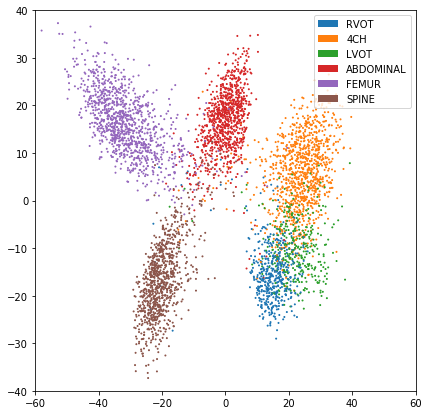

In [41]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in labels_train]
ax.scatter(projected[:,0], projected[:,1], c=colors, s=1)
ax.set_aspect(1.5)
ax.set_xlim([-60,60])
ax.set_ylim([-40,40])
recs = []
for i in range(0,6):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in class_names.values()],loc=1)

In [33]:
shifted_train = torch.cat((
    (1./2. * projected[(card_labels_train == 0)] + 1./2. * projected[(card_labels_train == 0)].mean(axis=0)) + torch.tensor([3.,-5.]),
    (3./4. * projected[(card_labels_train == 1)] + 1./4. * projected[(card_labels_train == 1)].mean(axis=0)) + torch.tensor([+5.,+2.]),
    (1./2. * projected[(card_labels_train == 2)] + 1./2. * projected[(card_labels_train == 2)].mean(axis=0)) + torch.tensor([0.,10.]),
    (1./2. * projected[(card_labels_train == 3)] + 1./2. * projected[(card_labels_train == 3)].mean(axis=0)) + torch.tensor([-8.,+4.]) 
))

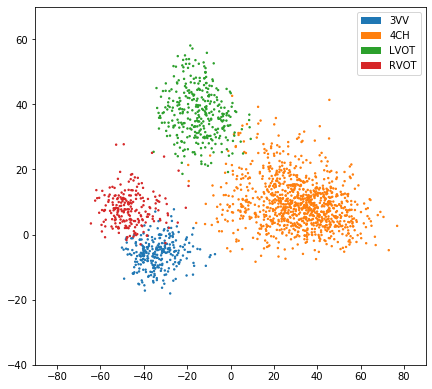

In [35]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in card_labels_train]
ax.scatter(shifted_train[:,0], shifted_train[:,1], c=colors, s=2)
ax.set_aspect(1.5)
ax.set_xlim([-90,90])
ax.set_ylim([-40,70])
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [37]:
train_sampler = sampler.WeightedRandomSampler(train_dataset.weight, 2000)
shifted_dataset = AlteredUSDataset((card_images_train, card_labels_train, shifted_train), transform=ds_transform['train'])
shifted_loader = DataLoader(shifted_dataset, batch_size=batch_size, shuffle=True)

In [39]:
torch.manual_seed(12)
torch.cuda.manual_seed(12)
torch.backends.cudnn.deterministic=True

model = get_model(json_opts.model)
#model.load_network(model.net, 'S', 50)
model.update_state(0)
model.optimizer.param_groups[0]['lr'] = 0.01

for epoch in tqdm(range(1, 30)):
    for (images, labels, emb) in shifted_loader:
        # Make a training update
        model.set_input(images, labels)
        model.optimize_parameters_altered(ptsne, emb.cuda(), 0.1)

    if epoch % 5 == 0:
        model.save(epoch)
        print_accuracy(model, 'train')
        print_accuracy(model, 'test')

    # if epoch == 25:
    #     model.update_learning_rate()

# for epoch in tqdm(range(1, 21)):
#     for idx, (images, labels, emb) in enumerate(shifted_loader):
#         # Make a training update
#         model.net.train()
#         model.set_input(images, labels)

#         model.optimize_parameters_altered(ptsne, emb.cuda(), 0.1)

#     model.save_network(model.net, 'emb_010_from_50', epoch, model.gpu_ids)
    
    # if epoch == 10:
    #      model.optimizer.param_groups[0]['lr'] = 0.0001

    # if epoch == 25:
    #     model.update_learning_rate()

        #model.update_learning_rate(metric=valid_err, epoch=epoch)


  0%|          | 0/29 [00:00<?, ?it/s]
Initialising model sononet2
Network is initialized
sononet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), 

In [190]:
logits_emb = {'train':[], 'test':[]}
for epoch in range(1, 20):
    model.load_network(model.net, 'emb_010_from_50', epoch)
    logits_emb['train'].append(get_logits(model, 'train', softmax=False)[0])
    logits_emb['test'].append(get_logits(model, 'test', softmax=False)[0])
logits_emb['train'] = torch.stack(logits_emb['train'])
logits_emb['test'] = torch.stack(logits_emb['test'])
torch.save(logits_emb, 'checkpoints/ifind1_sononet_8_andi/logits_emb_010_from_50.pt')

Loading the model emb_010_from_50 - epoch 1
Loading the model emb_010_from_50 - epoch 2
Loading the model emb_010_from_50 - epoch 3
Loading the model emb_010_from_50 - epoch 4
Loading the model emb_010_from_50 - epoch 5
Loading the model emb_010_from_50 - epoch 6
Loading the model emb_010_from_50 - epoch 7
Loading the model emb_010_from_50 - epoch 8
Loading the model emb_010_from_50 - epoch 9
Loading the model emb_010_from_50 - epoch 10
Loading the model emb_010_from_50 - epoch 11
Loading the model emb_010_from_50 - epoch 12
Loading the model emb_010_from_50 - epoch 13
Loading the model emb_010_from_50 - epoch 14
Loading the model emb_010_from_50 - epoch 15
Loading the model emb_010_from_50 - epoch 16
Loading the model emb_010_from_50 - epoch 17
Loading the model emb_010_from_50 - epoch 18
Loading the model emb_010_from_50 - epoch 19


In [191]:
logits_class = {'train':[], 'test':[]}
for epoch in range(1, 20):
    model.load_network(model.net, 'class_only_from_50', epoch)
    logits_class['train'].append(get_logits(model, 'train', softmax=False)[0])
    logits_class['test'].append(get_logits(model, 'test', softmax=False)[0])
logits_class['train'] = torch.stack(logits_class['train'])
logits_class['test'] = torch.stack(logits_class['test'])
torch.save(logits_emb, 'checkpoints/ifind1_sononet_8_andi/logits_class_only_from_50.pt')

Loading the model class_only_from_50 - epoch 1
Loading the model class_only_from_50 - epoch 2
Loading the model class_only_from_50 - epoch 3
Loading the model class_only_from_50 - epoch 4
Loading the model class_only_from_50 - epoch 5
Loading the model class_only_from_50 - epoch 6
Loading the model class_only_from_50 - epoch 7
Loading the model class_only_from_50 - epoch 8
Loading the model class_only_from_50 - epoch 9
Loading the model class_only_from_50 - epoch 10
Loading the model class_only_from_50 - epoch 11
Loading the model class_only_from_50 - epoch 12
Loading the model class_only_from_50 - epoch 13
Loading the model class_only_from_50 - epoch 14
Loading the model class_only_from_50 - epoch 15
Loading the model class_only_from_50 - epoch 16
Loading the model class_only_from_50 - epoch 17
Loading the model class_only_from_50 - epoch 18
Loading the model class_only_from_50 - epoch 19


In [41]:
logits_emb = dict()
logits_emb['train'] = get_logits(model, 'train', softmax=False)[0]
logits_emb['test'] = get_logits(model, 'test', softmax=False)[0]

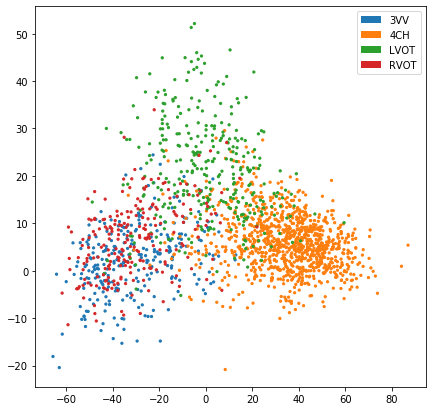

In [42]:
# projected_altered = ptsne(logits_class['train'][-1].cuda()).cpu().detach()
projected_altered = ptsne(logits_emb['train'].cuda()).cpu().detach()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in card_labels_train]
ax.scatter(projected_altered[:,0], projected_altered[:,1], c=colors, s=5)
#ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

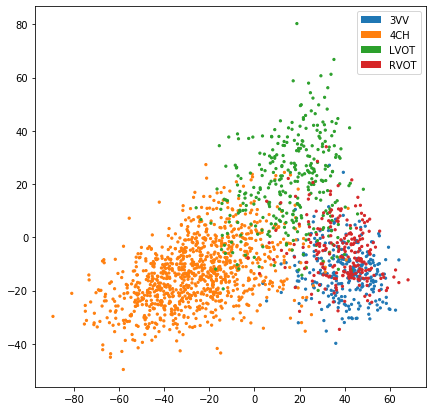

In [193]:
projected_altered = ptsne(logits_emb['train'][-1].cuda()).cpu().detach()
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
colors = [plt.cm.tab10.colors[i] for i in card_labels_train]
ax.scatter(projected_altered[:,0], projected_altered[:,1], c=colors, s=5)
#ax.set_aspect(1)
recs = []
for i in range(0,4):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=plt.cm.tab10.colors[i]))
ax.legend(recs, [i.decode('UTF-8') for i in us_data['label_names'].value[cardiac_classes]],loc=1)

In [44]:
def confmat(data):
    cf = torch.zeros(4,4, dtype=torch.int)
    for logits, label, in zip(*data):
        cf[label, logits.softmax(dim=0).argmax()] += 1
    return cf

In [45]:
def accuracy(data):
    cf = confmat(data)
    diag = cf.diagonal().sum()
    total = cf.sum()
    return diag.float() / total

In [46]:
def precision(data, c):
    cf = confmat(data)
    return cf[c,c].float() / cf[:,c].sum().float()

In [47]:
def recall(data, c):
    cf = confmat(data)
    return cf[c,c].float() / cf[c,:].sum().float()

In [48]:
def f_score(data, c):
    cf = confmat(data)
    prec = cf[c,c].float() / cf[:,c].sum().float()
    rec = cf[c,c].float() / cf[c,:].sum().float()
    return torch.sqrt(prec * rec)

In [56]:
f_score((logits_emb['train'], labels_train),3)

tensor(0.3764)

In [194]:
accs_train_class = [accuracy((log, card_labels_train)) for log in logits_class['train']]
accs_test_class = [accuracy((log, card_labels_test)) for log in logits_class['test']]

In [195]:
accs_train_emb = [accuracy((log, card_labels_train)) for log in logits_emb['train']]
accs_test_emb = [accuracy((log, card_labels_test)) for log in logits_emb['test']]

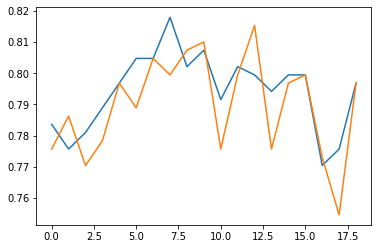

In [196]:
plt.plot(accs_test_class)
plt.plot(accs_test_emb)

In [197]:
f_score_0_test_class = [f_score((log, card_labels_test), 0) for log in logits_class['train']]
f_score_1_test_class = [f_score((log, card_labels_test), 1) for log in logits_class['train']]
f_score_2_test_class = [f_score((log, card_labels_test), 2) for log in logits_class['train']]
f_score_3_test_class = [f_score((log, card_labels_test), 3) for log in logits_class['train']]

In [198]:
f_score_0_test_emb = [f_score((log, card_labels_test), 0) for log in logits_emb['train']]
f_score_1_test_emb = [f_score((log, card_labels_test), 1) for log in logits_emb['train']]
f_score_2_test_emb = [f_score((log, card_labels_test), 2) for log in logits_emb['train']]
f_score_3_test_emb = [f_score((log, card_labels_test), 3) for log in logits_emb['train']]

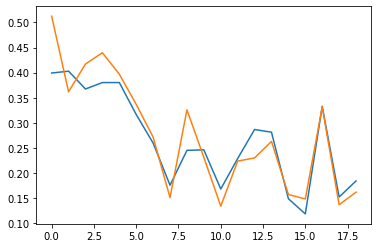

In [199]:
plt.plot(f_score_1_test_class)
plt.plot(f_score_1_test_emb)

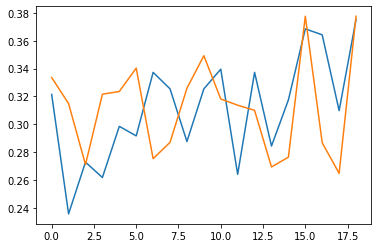

In [200]:
plt.plot(f_score_0_test_class)
plt.plot(f_score_0_test_emb)

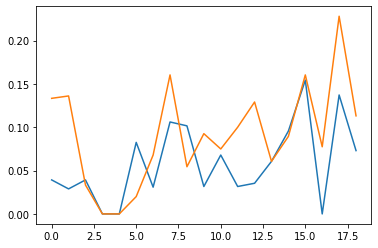

In [201]:
plt.plot(f_score_2_test_class)
plt.plot(f_score_2_test_emb)

In [204]:
plt.plot(f_score_3_train_class)
plt.plot(f_score_3_train_emb)

NameError: name 'f_score_3_train_class' is not defined

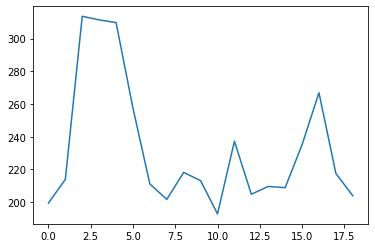

In [203]:
plt.plot([torch.nn.MSELoss()(ptsne(i.cuda()).cpu().detach(), shifted_train) for i in logits_emb['train']])

In [147]:
torch.nn.MSELoss()(ptsne(logits_emb['train'][-1].cuda()).cpu().detach(), projected_altered)

tensor(0.)

In [148]:
projected_altered

tensor([[ 42.7284, -15.9286],
        [ 47.1825, -14.0878],
        [ 41.6880, -17.5944],
        ...,
        [ 39.7183,  -3.3601],
        [ 49.3516,  10.9254],
        [ 53.0084,  -5.0605]])

In [150]:
ptsne(logits_emb['train'][-1].cuda()).cpu().detach()

tensor([[ 42.7284, -15.9286],
        [ 47.1825, -14.0878],
        [ 41.6880, -17.5944],
        ...,
        [ 39.7183,  -3.3601],
        [ 49.3516,  10.9254],
        [ 53.0084,  -5.0605]])